In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans, DBSCAN

### 1. App 可视化

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
def get_node2id(file=None):
    if not file:
        file = '../resources/node2id.pkl'
    node2id = pickle.load(open(file, 'rb'))
    print('load node2id from %s, it has %s nodes' % (file, len(node2id)))
    return node2id

In [4]:
node2id = get_node2id()
id2node = {}
for node, val in node2id.items():
    if 25467 > val[0] >= 25413:
        id2node[val[0] - 25413] = node
del node2id
node2id = {}
for id,node in id2node.items():
    node2id[node] = id

load node2id from ../resources/node2id.pkl, it has 25486 nodes


In [5]:
ids = list(id2node.keys())
applist = list(id2node.values())

In [6]:
def get_embeddings(file_name, node2id):  # 每个节点的embedding向量，给dnn的lookup用
    """
    embeddings的节点有的存成id, 有的是名称需要node2id
    :param file_name: embeddings file
    :param node2id: node:[id, type, count]
    :return:
    """
    embeddings_file = os.path.join("../network_embedding/embeddings_output/", file_name)
    with open(embeddings_file, 'r') as f:
        shape = tuple(map(int, f.readline().split()))
        print('node: %s, embedding_size: %s' % shape)
        embeddings = np.zeros((54, 128))
        for line in f:
            splits = line.split()
            if line.startswith('金山'):
                embeddings[node2id['金山WPS OFFICE手机版']] = list(map(float, splits[2:]))
            elif splits[0] in node2id:
                embeddings[node2id[splits[0]]] = list(map(float, splits[1:]))
            elif splits[0].isdigit() and int(splits[0])-25413 in ids:
                embeddings[int(splits[0]) - 25413] = list(map(float, splits[1:]))
    return embeddings

In [14]:
deepwalk_embeddings = get_embeddings('deepwalk.embeddings', node2id)
hin2vec_embeddings = get_embeddings('node_vectors.txt', node2id)

node: 25486, embedding_size: 128
node: 25486, embedding_size: 128


### app_cat

In [76]:
app_cat = pd.read_csv('../resources/app_cat的副本.csv', sep='\t', encoding='gbk')
app_cat.to_csv('../resources/app_cat.csv', index=False, encoding='gbk')
app2cat = dict(zip(list(app_cat['app']), list(app_cat['app_cat'])))
app_cat

,app,app_cat
0,金山WPS OFFICE手机版,办公管理
1,百度云,办公管理
2,钉钉,办公管理
3,百度地图,便捷生活
4,高德地图,便捷生活
5,墨迹天气,便捷生活
6,58同城,便捷生活
7,京东商城,电子商务
8,苏宁,电子商务
9,蘑菇街,电子商务


In [36]:
colorMap = {
    '电子商务': '#FF0033',  #红色
    '健康医疗': '#33CC33',  #绿色
    '旅行预订': '#66CCFF',  #浅蓝
    '汽车服务': '#333399',  #蓝紫
    '通讯聊天': '#9933CC',  #紫色
    '社交网络': '#FF6666',  #粉色
    '音乐音频': '#FF9900',  #橙色
    '便捷生活': '#FFFF00',  #黄色
}
def get_color(app):
    cat = app2cat[app]
    if cat not in colorMap:
        return '#CCCCCC'
    return colorMap[cat]

In [68]:
from matplotlib.font_manager import FontProperties
font=FontProperties(fname='/Library/Fonts/Songti.ttc', size=5)

def reduction_and_plot(model, data, file):
#     xmin, xmax = np.min(data, axis=0, keepdims=True), np.max(data, axis=0, keepdims=True)
#     data = (data - xmin)/(xmax - xmin)
#     data = data/np.sqrt(np.sum(np.square(data), axis=1, keepdims=True))
    data = model(n_components=2).fit_transform(data)
    fig = plt.figure()
    plt.scatter(data[:, 0], data[:, 1], s=0.4)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(id2node[i]), fontproperties=font,
                     color=get_color(id2node[i]))
#                      fontdict={'weight': 'bold', 'size': 10})
    plt.savefig(file, dpi=400)
    plt.show()

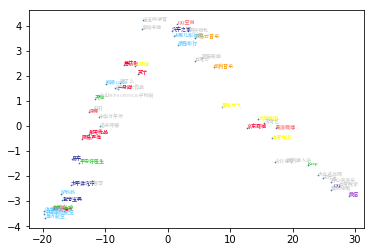

In [69]:
reduction_and_plot(PCA, hin2vec_embeddings, 'hin2vec.jpg')
!open hin2vec.jpg

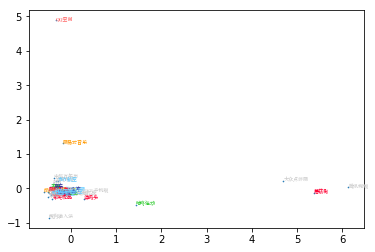

In [70]:
reduction_and_plot(PCA, deepwalk_embeddings, 'deepwalk.jpg')
!open deepwalk.jpg

In [72]:
pd.get_dummies(app_cat,prefix='hour', columns=['app_cat'])

,app,hour_个人工具,hour_亲子服务,hour_便捷生活,hour_健康医疗,hour_办公管理,hour_实用工具,hour_拍摄美化,hour_旅行预订,hour_汽车服务,hour_游戏服务,hour_电子商务,hour_电子阅读,hour_社交网络,hour_综合资讯,hour_美食外卖,hour_视频服务,hour_通讯聊天,hour_金融理财,hour_音乐音频
0,金山WPS OFFICE手机版,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,百度云,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,钉钉,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,百度地图,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,高德地图,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,墨迹天气,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,58同城,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,京东商城,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,苏宁,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,蘑菇街,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
